# Import Data

In [124]:
import pandas as pd

In [125]:
pd.set_option('display.max_columns', None)

In [126]:
df = pd.concat([pd.read_csv(f'../../../../data/F_feature_selection/feature_selection-{year}.csv', sep=';') for year in [2019, 2020, 2021, 2022]])
df_test = pd.read_csv('../../../../data/F_feature_selection/feature_selection-2023.csv', sep=';')

In [127]:
columns_to_drop = [
    'latitude', 'longitude',
    'pedestrian_location', 'pedestrian_action',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'age',
    'direction_of_travel_other'
]

object_type = ['role', 'age_group', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 'time_of_day']

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'sex', 
    
    #'pedestrian_location', 'pedestrian_action'
]

columns_to_int32 = [
    'location', 'type_of_collision', 'reserved_lane_present', 'horizontal_alignment', 'infrastructure', 'accident_situation', 'position',
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other',
    'motor_type_other','vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck',
    'vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler',
    'used_belt', 'used_helmet', 'used_child_restraint', 'used_airbag', 'impact_score', 'impact_score_other', 'impact_delta', 'surface_quality_indicator',
    'lighting_ordinal', 'weather_ordinal', 'injury_target', 'sex', 'day_of_week', 'speed_limit'
]

In [128]:
for x in [df, df_test]:
    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)    
    x.replace(-1, pd.NA, inplace=True)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    x[['vehicle_category_simplified', 'vehicle_category_simplified_other']] = x[['vehicle_category_simplified', 'vehicle_category_simplified_other']].fillna('no vehicle')
    x.dropna(inplace=True)
    x[columns_to_int32] = x[columns_to_int32].astype('int32')
    
    # Drop rows with impossible speed limit
    # France has a maximum speed limit of 130
    x.drop(index=x[x['speed_limit'] > 130].index, inplace=True)
 

C:\Users\David\AppData\Local\Temp\ipykernel_5548\4081092471.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)
C:\Users\David\AppData\Local\Temp\ipykernel_5548\4081092471.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)


In [129]:
num_cols = ['speed_limit', 'day_of_week', 'impact_score', 'impact_score_other', 'impact_delta', 'road_complexity_index', 'surface_quality_indicator', 'lighting_ordinal', 'weather_ordinal', 'vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck','vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler',]
cat_cols = df.columns.difference(num_cols + ['injury_target'])

In [130]:
X_train = df.drop(columns='injury_target')
y_train = df['injury_target']

X_test = df_test.drop(columns='injury_target')
y_test = df_test['injury_target']

# Models

In [117]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LassoCV, RidgeCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, train_test_split

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

#from mord import LogisticIT, LogisticAT

In [131]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy={0:68000, 1:68000, 2:68000})),
    ('classifier', RidgeClassifierCV(alphas=[0.1*x for x in range(1, 101)], scoring='f1_macro'))
])
pipeline.fit(X_train, y_train)

,steps,"[('transform', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.83      0.74      0.78     51051
           1       0.62      0.51      0.56     39476
           2       0.43      0.73      0.54     17440

    accuracy                           0.66    107967
   macro avg       0.63      0.66      0.63    107967
weighted avg       0.69      0.66      0.66    107967



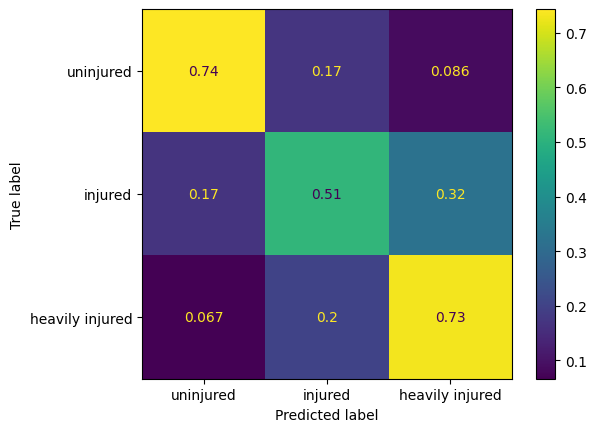

In [132]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [133]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('classifier', BalancedRandomForestClassifier(n_jobs=-1, n_estimators=100, sampling_strategy='not minority', replacement=True, bootstrap=True))
])
pipeline.fit(X_train, y_train)

,steps,"[('transform', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.86      0.75      0.80     51051
           1       0.64      0.55      0.59     39476
           2       0.44      0.75      0.56     17440

    accuracy                           0.67    107967
   macro avg       0.65      0.68      0.65    107967
weighted avg       0.71      0.67      0.68    107967



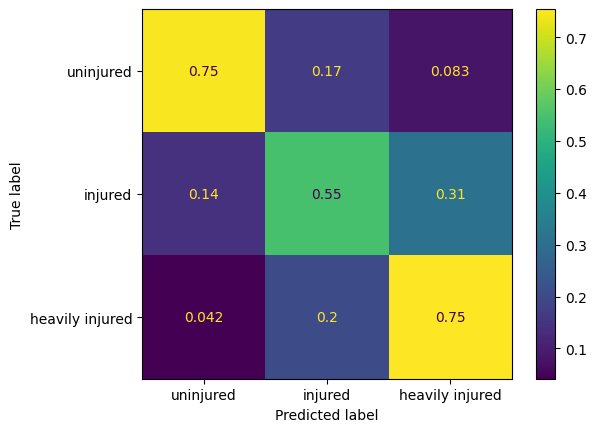

In [134]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', LogisticAT())
])

search_grid = {
    'classifier__alpha': [0.1, 1, 10]
}

randomized_search = RandomizedSearchCV(estimator=pipeline, scoring='f1_macro', n_jobs=3, random_state=42, param_distributions=search_grid)

randomized_search.fit(X_train, y_train)

print(f'Best params: {randomized_search.best_params_}')
print(f'Best score: {randomized_search.best_score_}')

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'classifier__alpha': 1}
Best score: 0.6160105740346877


c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.88      0.68      0.76     51051
           1       0.53      0.60      0.56     39476
           2       0.45      0.63      0.53     17440

    accuracy                           0.64    107967
   macro avg       0.62      0.63      0.62    107967
weighted avg       0.68      0.64      0.65    107967



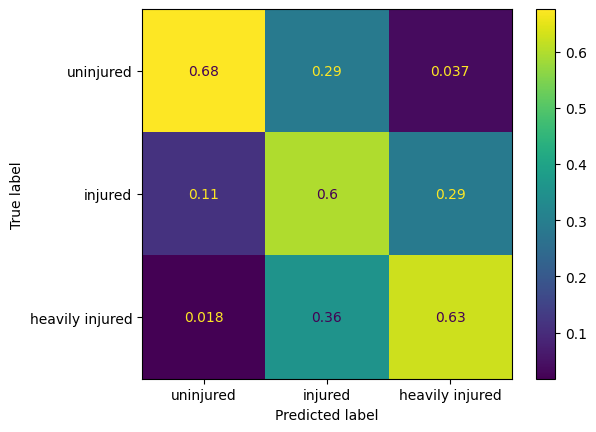

In [255]:
y_pred = randomized_search.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [36]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', LassoCV(n_jobs=-1))
])

c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+01, tolerance: 8.338e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e+01, tolerance: 8.338e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the numb

              precision    recall  f1-score   support

           0       0.90      0.63      0.74     51051
           1       0.51      0.57      0.54     39476
           2       0.43      0.68      0.53     17440

    accuracy                           0.62    107967
   macro avg       0.61      0.63      0.60    107967
weighted avg       0.68      0.62      0.63    107967



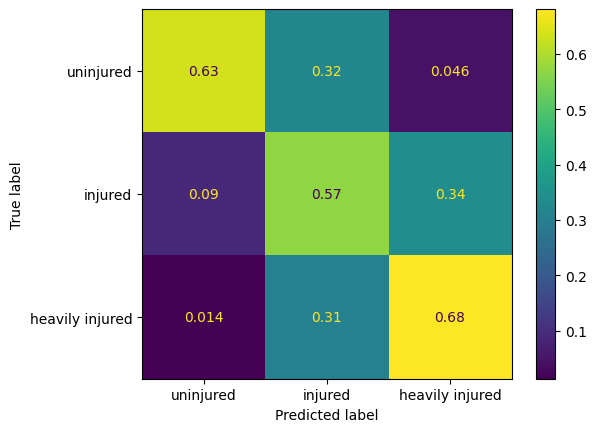

In [37]:
under_sampler = RandomUnderSampler(sampling_strategy='not minority', replacement=True) 
X_tr, y_tr = under_sampler.fit_resample(X_train, y_train)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, shuffle=True
)

pipeline.fit(X_tr, y_tr)
y_val_cont = pipeline.predict(X_val)

# Helpers to convert continuous preds to ordinal classes
def round_clip(y_cont):
    return np.clip(np.rint(y_cont), 0, 2).astype(int)

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

# Tune ordinal thresholds on validation
best = (-1, (0.5, 1.5, 2.5))
g1 = np.arange(0.3, 0.8, 0.01)
g2 = np.arange(1.3, 1.8, 0.01)
for t1 in g1:
    for t2 in g2:
        if t2 <= t1: 
            continue
        yv = apply_thresholds(y_val_cont, t1, t2)
        score = f1_score(y_val, yv, average='macro')
        if score > best[0]:
            best = (score, (t1, t2))

score, (t1, t2) = best


y_pred_cont = pipeline.predict(X_test)
y_pred = apply_thresholds(y_pred_cont, t1, t2)


print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [140]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', RidgeCV(scoring='neg_root_mean_squared_error'))
])

              precision    recall  f1-score   support

           0       0.88      0.65      0.75     51051
           1       0.51      0.56      0.53     39476
           2       0.43      0.66      0.52     17440

    accuracy                           0.62    107967
   macro avg       0.61      0.62      0.60    107967
weighted avg       0.67      0.62      0.63    107967



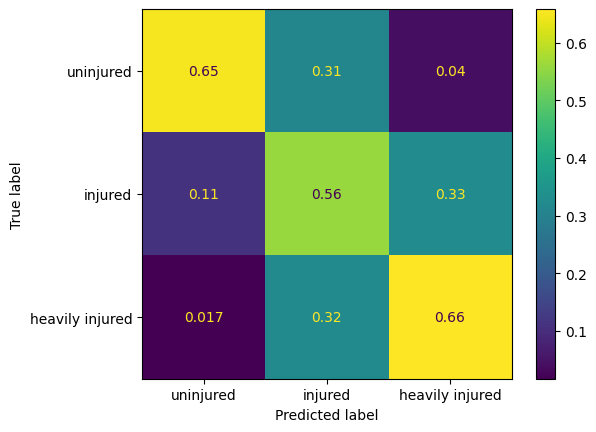

In [141]:
under_sampler = RandomUnderSampler(sampling_strategy='not minority', replacement=True) 

X_tr, y_tr = under_sampler.fit_resample(X_train, y_train)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, shuffle=True
)

pipeline.fit(X_tr, y_tr)
y_val_cont = pipeline.predict(X_val)

# Helpers to convert continuous preds to ordinal classes
def round_clip(y_cont):
    return np.clip(np.rint(y_cont), 0, 2).astype(int)

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

# Tune ordinal thresholds on validation
best = (-1, (0.5, 1.5, 2.5))
g1 = np.arange(0.05, 0.95, 0.01)
g2 = np.arange(1.05, 1.95, 0.01)
for t1 in g1:
    for t2 in g2:
        if t2 <= t1: 
            continue
        yv = apply_thresholds(y_val_cont, t1, t2)
        score = f1_score(y_val, yv, average='macro')
        if score > best[0]:
            best = (score, (t1, t2))

score, (t1, t2) = best


y_pred_cont = pipeline.predict(X_test)
y_pred = apply_thresholds(y_pred_cont, t1, t2)
#y_pred = round_clip(y_pred_cont)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [ ]:
coef = pipeline.steps[2][1].coef_
feature_names = pipeline.steps[0][1].get_feature_names_out()

df_coef = pd.DataFrame({
    'feature': feature_names,
    'coef': coef
})

df_coef.sort_values(by='coef', ascending=False).head(50)


,feature,coef
200,cat__vehicle_category_simplified_other_no vehicle,0.703940
195,cat__vehicle_category_simplified_powered_2_3_w...,0.576069
201,cat__vehicle_category_simplified_other_other,0.481944
137,cat__mobile_obstacle_struck_4,0.466457
9,cat__age_group_senior,0.421015
177,cat__sex_2,0.393042
176,cat__sex_1,0.310060
199,cat__vehicle_category_simplified_other_light_m...,0.251032
8,cat__age_group_middle_aged,0.245079
56,cat__infrastructure_7,0.230458


c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


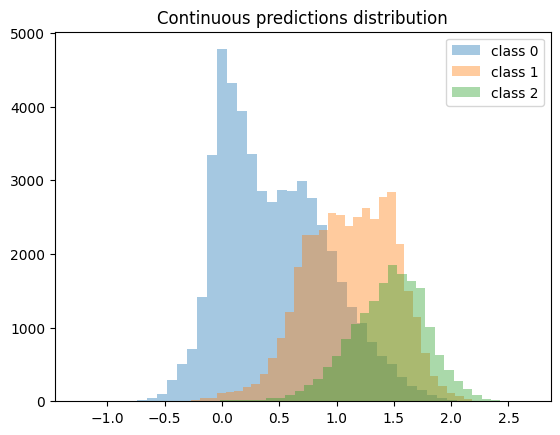

In [39]:
# ...existing code...
import matplotlib.pyplot as plt
y_cont_test = pipeline.predict(X_test)
for cls in [0,1,2]:
    plt.hist(y_cont_test[y_test==cls], bins=40, alpha=0.4, label=f'class {cls}')
plt.legend(); plt.title('Continuous predictions distribution'); plt.show()
# ...existing code...

In [304]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

transformer = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('num', 'passthrough', num_cols)
], remainder='drop')

X_tr = transformer.fit_transform(X_train)
X_te = transformer.transform(X_test)

# Categorical cols are first block -> indices 0 .. len(cat_cols)-1
cat_idx = list(range(len(cat_cols)))

sw = compute_sample_weight(class_weight='balanced', y=y_train)

gb = HistGradientBoostingClassifier(
    categorical_features=cat_idx,
    learning_rate=0.05,
    max_depth=6,
    max_iter=300,
    min_samples_leaf=50,
    l2_regularization=1.0
)

gb.fit(X_tr, y_train, sample_weight=sw)

,loss,'log_loss'
,learning_rate,0.05
,max_iter,300
,max_leaf_nodes,31
,max_depth,6
,min_samples_leaf,50
,l2_regularization,1.0
,max_features,1.0
,max_bins,255
,categorical_features,"[0, 1, ...]"
,monotonic_cst,None


              precision    recall  f1-score   support

           0       0.87      0.75      0.80     51051
           1       0.64      0.62      0.63     39476
           2       0.48      0.71      0.57     17440

    accuracy                           0.69    107967
   macro avg       0.66      0.69      0.67    107967
weighted avg       0.72      0.69      0.70    107967



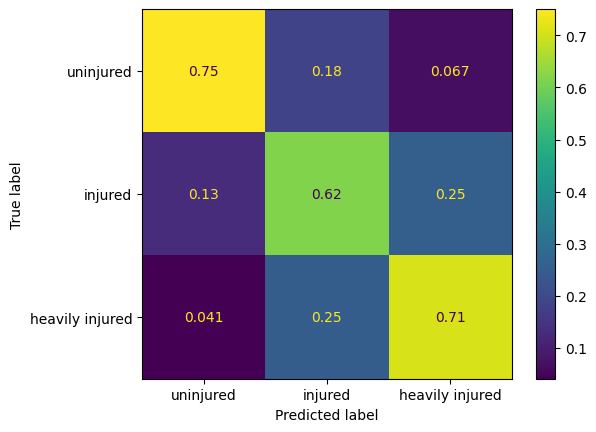

In [305]:
y_pred = gb.predict(X_te)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [70]:
df

,location,type_of_collision,reserved_lane_present,horizontal_alignment,infrastructure,accident_situation,speed_limit,position,sex,pedestrian_location,pedestrian_action,fixed_obstacle_struck,mobile_obstacle_struck,initial_point_of_impact,main_maneuver_before_accident,motor_type,fixed_obstacle_struck_other,mobile_obstacle_struck_other,initial_point_of_impact_other,main_maneuver_before_accident_other,motor_type_other,vehicle_category_involved_bicycle,vehicle_category_involved_bus_coach,vehicle_category_involved_hgv_truck,vehicle_category_involved_light_motor_vehicle,vehicle_category_involved_other,vehicle_category_involved_powered_2_3_wheeler,time_of_day,day_of_week,age_group,used_belt,used_helmet,used_child_restraint,used_airbag,vehicle_category_simplified,impact_score,vehicle_category_simplified_other,impact_score_other,impact_delta,road_complexity_index,surface_quality_indicator,role,lighting_ordinal,weather_ordinal,injury_target
20,1,5,0,1,0,1,90,1,1,0,0,0,2,1,1,1,0,2,4,1,1,0,0,0,3,0,0,Evening_Rush,3,young_adult,1,0,0,0,light_motor_vehicle,4,light_motor_vehicle,4,0,3.076923,1,driver,3,0,0
21,1,5,0,1,0,1,90,1,2,0,0,0,2,4,1,1,0,2,4,1,1,0,0,0,3,0,0,Evening_Rush,3,middle_aged,1,0,0,0,light_motor_vehicle,4,light_motor_vehicle,4,0,3.076923,1,driver,3,0,0
22,1,5,0,1,0,1,90,1,2,0,0,0,2,4,1,1,0,2,4,1,1,0,0,0,3,0,0,Evening_Rush,3,young_adult,1,0,0,0,light_motor_vehicle,4,light_motor_vehicle,4,0,3.076923,1,driver,3,0,1
24,2,2,0,1,0,1,50,1,1,0,0,0,2,2,1,1,0,2,4,1,1,0,0,0,1,0,1,Midday,3,young_adult,1,0,0,0,light_motor_vehicle,4,powered_2_3_wheeler,3,1,4.230769,0,driver,0,0,0
25,2,6,0,1,0,1,50,10,1,2,3,-1,-1,-1,-1,-1,0,1,3,1,1,0,0,0,1,0,0,Midday,3,middle_aged,0,0,0,0,unknown,1,light_motor_vehicle,4,-3,4.230769,1,pedestrian,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126269,1,6,0,2,0,3,80,1,1,0,0,2,0,3,1,1,-1,-1,-1,-1,-1,0,0,0,1,0,0,Morning_Rush,5,adult,1,0,0,0,light_motor_vehicle,4,no vehicle,0,4,3.461538,1,driver,3,0,2
126270,1,6,0,2,0,3,80,1,1,0,0,2,0,1,1,1,-1,-1,-1,-1,-1,0,0,0,1,0,0,Night,5,adult,0,0,0,0,light_motor_vehicle,4,no vehicle,0,4,3.461538,0,driver,3,0,2
126271,1,3,0,1,0,1,80,1,2,0,0,0,0,8,19,1,0,2,1,1,1,0,0,0,2,0,0,Morning_Rush,5,young_adult,1,0,0,0,light_motor_vehicle,4,light_motor_vehicle,4,0,4.615385,1,driver,0,0,0
126272,1,3,0,1,0,1,80,8,2,0,0,0,0,8,19,1,0,2,1,1,1,0,0,0,2,0,0,Morning_Rush,5,young_adult,1,0,0,0,light_motor_vehicle,4,light_motor_vehicle,4,0,4.615385,1,passenger,0,0,2


In [81]:
from catboost import CatBoostClassifier

cat_idx = [X_train.columns.get_loc(c) for c in X_train.columns if c not in num_cols]

model = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    #boosting_type='Ordered',
    cat_features=cat_idx
)
model.fit(X_train, y_train)

0:	learn: 0.5720124	total: 108ms	remaining: 1m 47s
1:	learn: 0.5720124	total: 215ms	remaining: 1m 47s
2:	learn: 0.5729070	total: 273ms	remaining: 1m 30s
3:	learn: 0.5730494	total: 296ms	remaining: 1m 13s
4:	learn: 0.5730494	total: 320ms	remaining: 1m 3s
5:	learn: 0.5808668	total: 343ms	remaining: 56.8s
6:	learn: 0.5725437	total: 366ms	remaining: 51.9s
7:	learn: 0.5818551	total: 389ms	remaining: 48.2s
8:	learn: 0.5843815	total: 412ms	remaining: 45.4s
9:	learn: 0.5847415	total: 435ms	remaining: 43.1s
10:	learn: 0.5847415	total: 458ms	remaining: 41.2s
11:	learn: 0.5854638	total: 478ms	remaining: 39.4s
12:	learn: 0.5854692	total: 498ms	remaining: 37.8s
13:	learn: 0.5854595	total: 518ms	remaining: 36.4s
14:	learn: 0.5856815	total: 537ms	remaining: 35.3s
15:	learn: 0.5864196	total: 562ms	remaining: 34.5s
16:	learn: 0.5868301	total: 581ms	remaining: 33.6s
17:	learn: 0.5866471	total: 600ms	remaining: 32.7s
18:	learn: 0.5873908	total: 621ms	remaining: 32s
19:	learn: 0.5872912	total: 641ms	remai

              precision    recall  f1-score   support

           0       0.86      0.75      0.80     51051
           1       0.65      0.62      0.63     39476
           2       0.48      0.72      0.58     17440

    accuracy                           0.70    107967
   macro avg       0.66      0.70      0.67    107967
weighted avg       0.72      0.70      0.70    107967



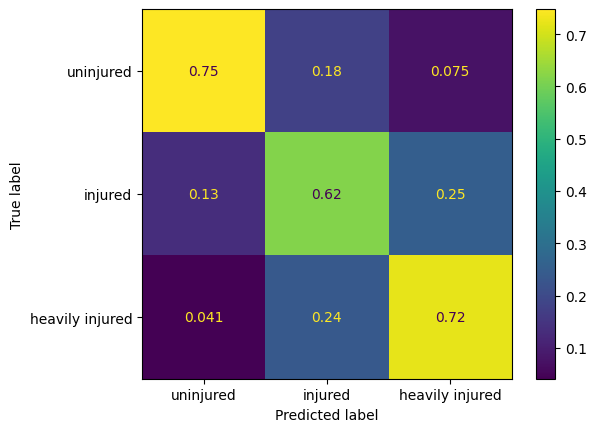

In [82]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [43]:
from sklearn.multiclass import OneVsRestClassifier

catBoost = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    boosting_type='Ordered',
    auto_class_weights='Balanced',
    cat_features=cat_idx
)

estimator = OneVsRestClassifier(estimator=catBoost)

estimator.fit(X_train, y_train)

Learning rate set to 0.024186
0:	learn: 0.7955055	total: 499ms	remaining: 8m 18s
1:	learn: 0.7954322	total: 723ms	remaining: 6m
2:	learn: 0.7954269	total: 950ms	remaining: 5m 15s
3:	learn: 0.7990720	total: 1.17s	remaining: 4m 51s
4:	learn: 0.7960325	total: 1.39s	remaining: 4m 37s
5:	learn: 0.7991390	total: 1.63s	remaining: 4m 30s
6:	learn: 0.7988343	total: 1.88s	remaining: 4m 26s
7:	learn: 0.7985444	total: 2.1s	remaining: 4m 20s
8:	learn: 0.7991050	total: 2.32s	remaining: 4m 15s
9:	learn: 0.7984609	total: 2.55s	remaining: 4m 12s
10:	learn: 0.7985522	total: 2.77s	remaining: 4m 9s
11:	learn: 0.7984911	total: 3s	remaining: 4m 6s
12:	learn: 0.7987624	total: 3.23s	remaining: 4m 5s
13:	learn: 0.7987720	total: 3.46s	remaining: 4m 3s
14:	learn: 0.7989131	total: 3.69s	remaining: 4m 2s
15:	learn: 0.7990581	total: 3.91s	remaining: 4m
16:	learn: 0.7990815	total: 4.14s	remaining: 3m 59s
17:	learn: 0.7990793	total: 4.37s	remaining: 3m 58s
18:	learn: 0.7989757	total: 4.59s	remaining: 3m 57s
19:	learn

,estimator,<catboost.cor...001F21A5E6360>
,n_jobs,None
,verbose,0


              precision    recall  f1-score   support

           0       0.87      0.75      0.80     51051
           1       0.63      0.65      0.64     39476
           2       0.49      0.66      0.56     17440

    accuracy                           0.70    107967
   macro avg       0.66      0.69      0.67    107967
weighted avg       0.72      0.70      0.71    107967



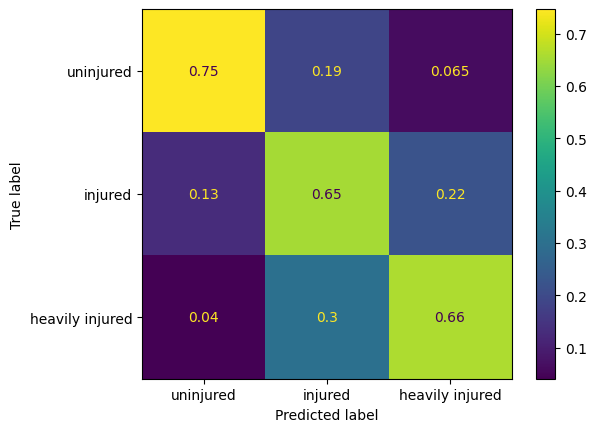

In [44]:
y_pred = estimator.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [53]:
classifier = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    # eval_metric='TotalF1',
    eval_metric='MultiClassOneVsAll',
    # task_type='GPU',
    # devices='0',
    boosting_type='Ordered',
    cat_features=cat_idx,
    # verbose=False
)

pipeline = ImbPipeline([
    ('under_sampler', RandomUnderSampler(sampling_strategy={0:5000, 1:5000, 2:5000})),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

0:	learn: 0.6828018	total: 212ms	remaining: 3m 32s
1:	learn: 0.6730645	total: 418ms	remaining: 3m 28s
2:	learn: 0.6639929	total: 670ms	remaining: 3m 42s
3:	learn: 0.6554287	total: 897ms	remaining: 3m 43s
4:	learn: 0.6472192	total: 1.11s	remaining: 3m 40s
5:	learn: 0.6392828	total: 1.33s	remaining: 3m 40s
6:	learn: 0.6317665	total: 1.52s	remaining: 3m 35s
7:	learn: 0.6244362	total: 1.72s	remaining: 3m 32s
8:	learn: 0.6177453	total: 1.94s	remaining: 3m 34s
9:	learn: 0.6115079	total: 2.17s	remaining: 3m 35s
10:	learn: 0.6054985	total: 2.38s	remaining: 3m 34s
11:	learn: 0.5999261	total: 2.6s	remaining: 3m 33s
12:	learn: 0.5945041	total: 2.82s	remaining: 3m 34s
13:	learn: 0.5890449	total: 3.05s	remaining: 3m 34s
14:	learn: 0.5839996	total: 3.27s	remaining: 3m 34s
15:	learn: 0.5790336	total: 3.49s	remaining: 3m 34s
16:	learn: 0.5742712	total: 3.71s	remaining: 3m 34s
17:	learn: 0.5696345	total: 3.92s	remaining: 3m 33s
18:	learn: 0.5655110	total: 4.14s	remaining: 3m 33s
19:	learn: 0.5613534	to

,steps,"[('under_sampler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,"{0: 5000, 1: 5000, 2: 5000}"
,random_state,None
,replacement,False


              precision    recall  f1-score   support

           0       0.86      0.73      0.79     51051
           1       0.62      0.59      0.60     39476
           2       0.45      0.71      0.55     17440

    accuracy                           0.67    107967
   macro avg       0.64      0.67      0.65    107967
weighted avg       0.71      0.67      0.68    107967



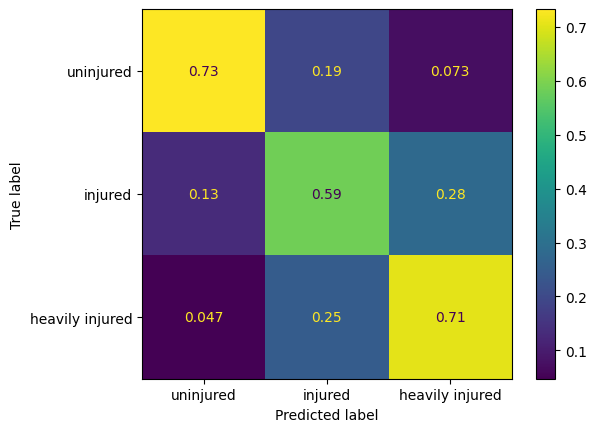

In [54]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()